In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Example Usage with the Beta Distribution ---
from scipy.stats import beta


from alignsim.simulate import (
    generate_uniform_confusion_matrix, 
    generate_annotations, 
    generate_fixed_accuracy_annotations,
    generate_latent_bernoulli_results
)
from alignsim.calculate import (
    calculate_3d_agreement,
    calculate_empirical_accuracy,
    calculate_geirhos_error_matrix,
    calculate_geirhos_metrics,
    calculate_geirhos_from_validations
)

from alignsim.distributions import (
    get_beta_dist
)

from alignsim.experiments_ec import (
    run_accuracy_vs_kappa_sim,
    run_facility_experiment
)

from alignsim.visualise import (
    plot_latent_facility_ec_experiment
)


## Experiment: Independent Annotators

This experiment simulates annotations from two systems with different accuracies but where annotations are otherwise generated uniformly. For this, we first randomly assign the appropriate number of correct annotations across all items then we sample errors uniformly for the remaining items across classes.

We fix system 1 accuracy and vary system 2's accuracy and then explore how the resulting annotations lead to empirical EC scores. Note that these have mean EC close to zero for all values of system 2 accuracy, but the variance for EC grows as system 2 accuracy increases.  

In [11]:
# Initialise parameters
K = 16
samples_per_class = 80
gt = np.repeat(np.arange(K), samples_per_class)
fixed_acc1 = 0.9
acc2_range = np.linspace(0.1, 0.95, 20)

# Execute simulation
df_results = run_accuracy_vs_kappa_sim(gt, fixed_acc1, acc2_range, K)

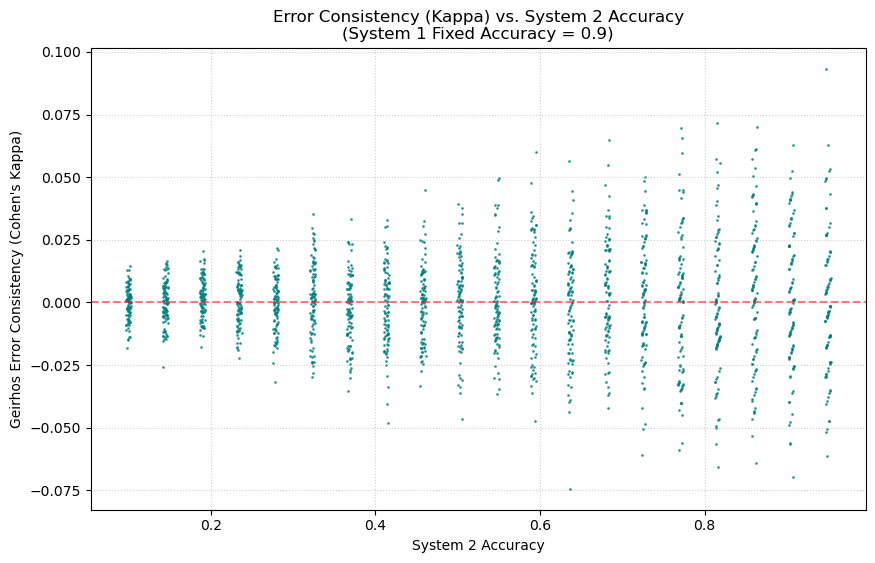

In [12]:
# Visualise results
n_instances = len(df_results['accuracy_2'])
gap = df_results['kappa'][1]-df_results['kappa'][0]
jitter_delta = gap/3
jitter = np.random.uniform(-jitter_delta, jitter_delta, n_instances)
plt.figure(figsize=(10, 6))
plt.scatter(df_results['accuracy_2']+jitter, df_results['kappa']+jitter, color='teal', edgecolor=None, s=1, alpha=0.7)


plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.title(f'Error Consistency (Kappa) vs. System 2 Accuracy\n(System 1 Fixed Accuracy = {fixed_acc1})')
plt.xlabel('System 2 Accuracy')
plt.ylabel("Geirhos Error Consistency (Cohen's Kappa)")
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## Experiment: Item Level Difficulty

This experiment explores the influence of a shared item facility (one minus the difficulty) on the error consistency. It asks the following question, if some items are easier and some are more difficult for both systems, then what influence does this have on the EC measure of alignment. Put simply, if there is an external measure of shared difficulty/easyness, then if system 1 makes an error on a given item, this indicates that the shared difficult of that item is more likely to be higher, and hence system 2 will be  more likely to make an error on the same item. Similarly, if system 1 is correct, the item is more likely easy and hence system 2 is more likely to be correct. The simplifying assumption made here is that both systems have the same latent item facility. This could be relaxed in future experiments.

Here we generate the latent item facilities sampled from a beta distribution with known mean and variance. For vanishingly small variance then all items will have the same facility and hence we are back in the domain of uncorrelated errors. As the variance increases, then the individual facility has a greater influence on the agreement between systems. Note that higher variances are not possible for mean facilities close to $0$ or $1$.




In [2]:
N = 1000
# A Beta(8, 2) distribution is skewed towards 1.0 (mostly easy items)
easy_dist = beta(8, 2)
p_samples, labels1, labels2 = generate_latent_bernoulli_results(N, easy_dist)

print(f"Generated {len(labels1)} labels.")
print(f"Empirical Accuracy 1: {np.mean(labels1):.4f}")
print(f"Empirical Accuracy 2: {np.mean(labels2):.4f}")


Generated 1000 labels.
Empirical Accuracy 1: 0.8050
Empirical Accuracy 2: 0.8050


In [3]:

# --- Example Usage ---
# Aiming for a mean accuracy of 0.8 with a tight variance of 0.02
mean_acc = 0.8
variance = 0.05

print(f"Accuracy prior: mean {mean_acc:.3f}, variance {variance:.3f}")
dist = get_beta_dist(mean_acc, variance)
print(f"Alpha: {dist.args[0]:.2f}, Beta: {dist.args[1]:.2f}")

p_samples, validations1, validations2  = generate_latent_bernoulli_results(N, dist)

print(f"Generated {len(validations1)} validations for each annotator.")
print(f"Empirical Accuracy 1: {np.mean(validations1):.4f}")
print(f"Empirical Accuracy 2: {np.mean(validations2):.4f}")



Accuracy prior: mean 0.800, variance 0.050
Alpha: 1.76, Beta: 0.44
Generated 1000 validations for each annotator.
Empirical Accuracy 1: 0.8090
Empirical Accuracy 2: 0.8020


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_agreement(p_samples, validations1, validations2):
    reorder = np.argsort(p_samples)
    p_samples = p_samples[reorder]
    validations1 = validations1[reorder]
    validations2 = validations2[reorder]
#     # 1. Generate latent probabilities
#     p_samples = np.sort(distribution.rvs(size=n)) # Sort to make the plot readable
    
#     # 2. Generate shared-difficulty labels
#     # Using the same logic as your function
#     ann1 = (np.random.random(n) < p_samples).astype(int)
#     ann2 = (np.random.random(n) < p_samples).astype(int)
    
    # 3. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 4]})
    
    # Left bar: The latent probability (the 'Difficulty' gradient)
    ax1.imshow(p_samples[:, np.newaxis], aspect='auto', cmap='RdYlGn', interpolation='nearest')
    ax1.set_title("Latent $p_i$")
    ypositions = np.linspace(0,N,6).astype(int)[:-1]
    print(f"ypositions = {ypositions}")
    ax1.set_yticks(ypositions, np.round(p_samples[ypositions],3))
    ax1.set_xticks([])
    ax1.set_ylabel("Sample Facility (1 - Difficulty)")
    
    # Right heatmap: Annotator Outcomes
    data = np.stack([validations1, validations2], axis=1)
    ax2.imshow(data, aspect='auto', cmap='Reds_r', interpolation='nearest') # Red = Incorrect (0)
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(['System 1', 'System 2'])
    ax2.set_title("Outcomes\n(White=Correct, Red=Error)")
    
    plt.tight_layout()

### Illustrating latent facilities

This plot shows how the facility of an item causes the correctness/errors of the two systems to become correlated. The items are ordered from harder (top) to easier (bottom). Note that harder items cause more errors (burgundy) in both annotators, and so are more likely to lead to joint errors. Easier items cause more correct annotations (white) in both annotators and so are more likely to lead to jointly correct instances. These will increase the counts of the diagonal terms in Geirhos' et al.'s error matrix, and hence boost EC values.

ypositions = [  0 200 400 600 800]
Corresponding EC: 0.36495577028631226 


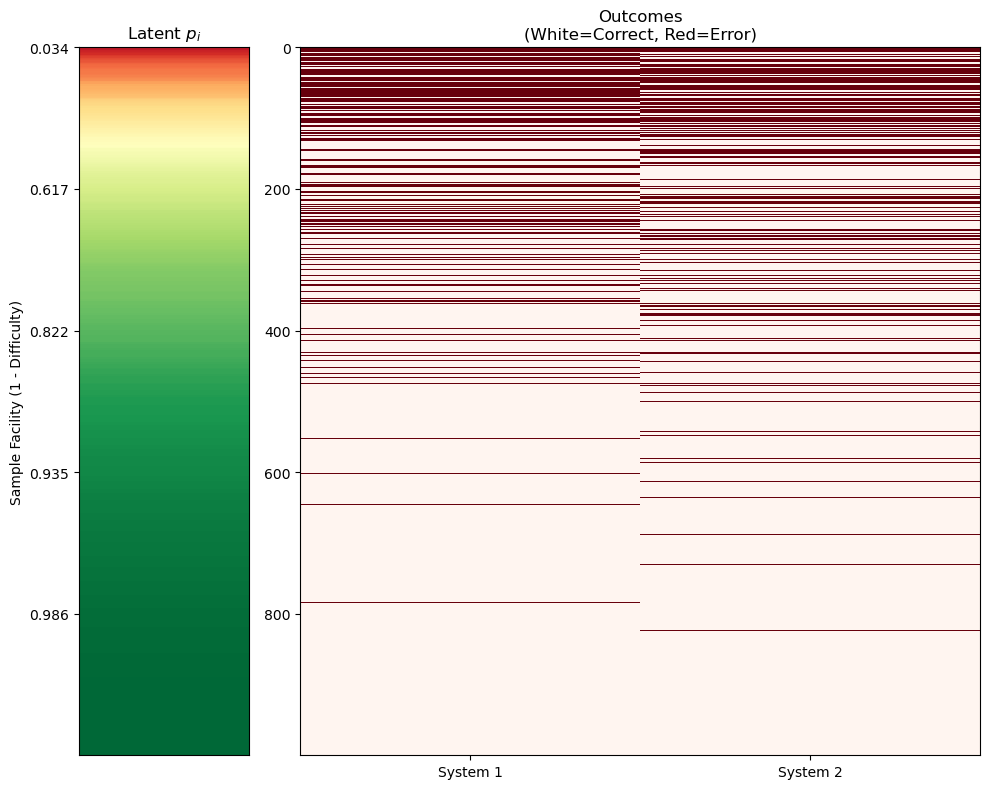

In [5]:

plot_latent_agreement(p_samples, validations1, validations2)

mtx = calculate_geirhos_from_validations(validations1, validations2)
metrics = calculate_geirhos_metrics(mtx)
print(f"Corresponding EC: {metrics['kappa']} ")

In [ ]:
# Shared parameters
means = np.linspace(0.05, 0.95, 19)
N = 1280
n_trials=50

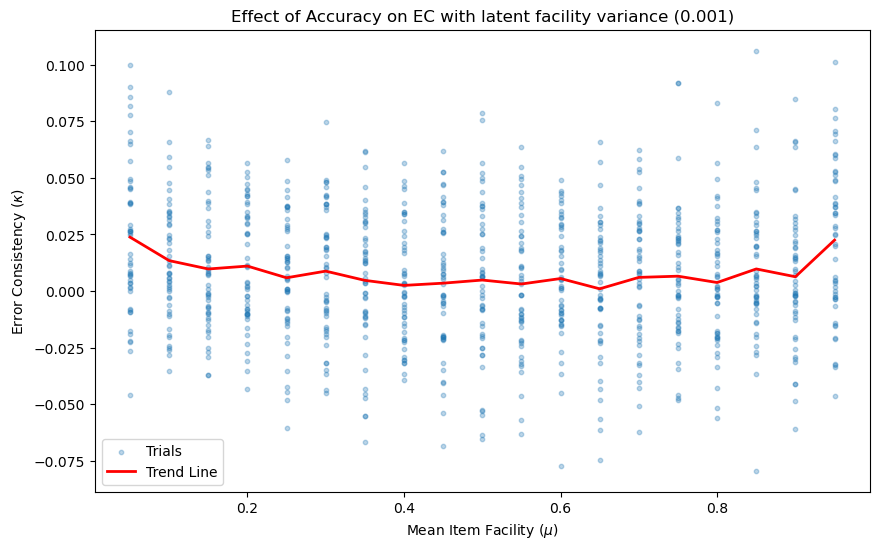

In [6]:
fixed_variance = 0.001
df_sim = run_facility_experiment(means, fixed_variance, N=N, n_trials=n_trials)

plot_latent_facility_ec_experiment(
        df_sim,
        fixed_variance,
        figsize=(10, 6)
)

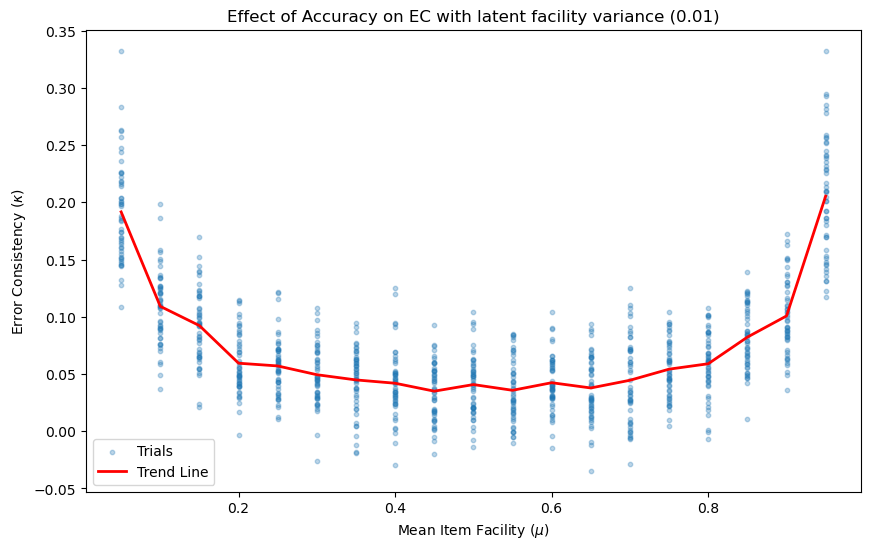

In [7]:
fixed_variance = 0.01
df_sim = run_facility_experiment(means, fixed_variance, N=N, n_trials=n_trials)

plot_latent_facility_ec_experiment(
        df_sim,
        fixed_variance,
        figsize=(10, 6)
)


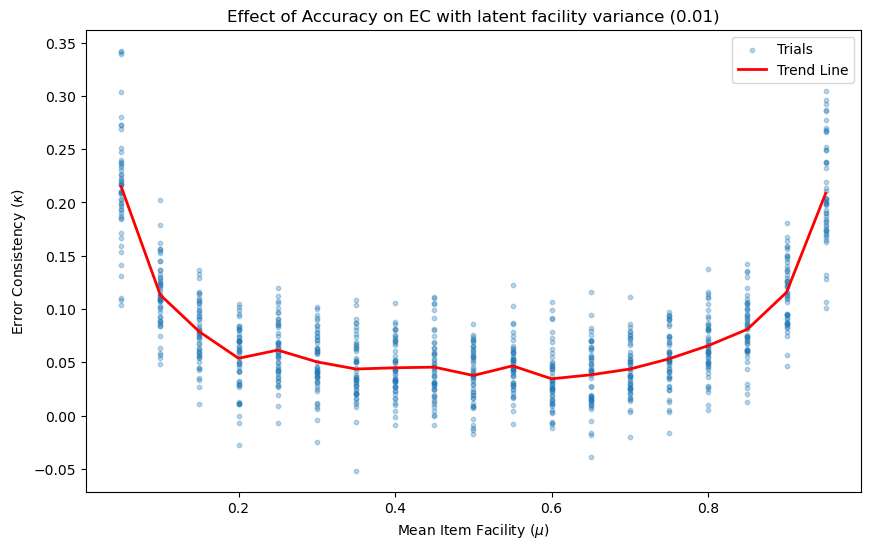

In [8]:
fixed_variance = 0.01
df_sim = run_facility_experiment(means, fixed_variance, N=N, n_trials=n_trials)

plot_latent_facility_ec_experiment(
        df_sim,
        fixed_variance,
        figsize=(10, 6)
)


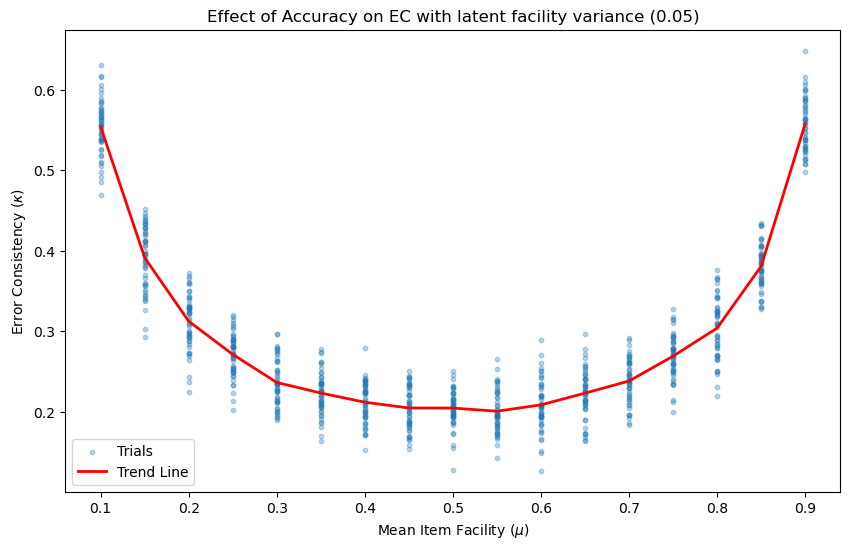

In [9]:
fixed_variance = 0.05
df_sim = run_facility_experiment(means, fixed_variance, N=N, n_trials=n_trials)

plot_latent_facility_ec_experiment(
        df_sim,
        fixed_variance,
        figsize=(10, 6)
)


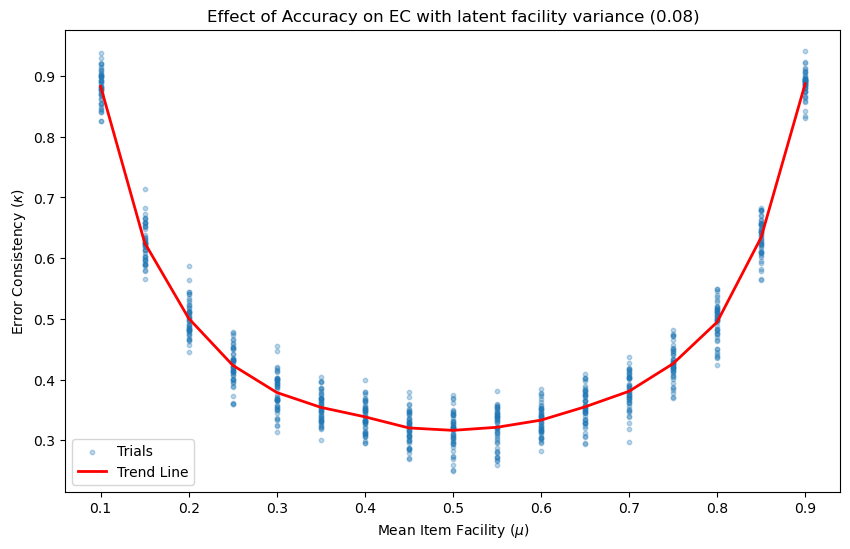

In [10]:
fixed_variance = 0.08
df_sim = run_facility_experiment(means, fixed_variance, N=N, n_trials=n_trials)

plot_latent_facility_ec_experiment(
        df_sim,
        fixed_variance,
        figsize=(10, 6)
)
